## Imports

In [1]:
import os
import sys
sys.path.append('/home/sardarchitect/repos/github.com/ucsd_capstone/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch
import seaborn as sns
import torch
import cv2 as cv

In [11]:
from streetstudy.data import virat
from streetstudy.common import display
from streetstudy.model import yolo

## Load Data

In [3]:
# Get video data
video_df = virat.get_dataset_df()
video_df.head()

,path,num_frames,duration,image_width,image_height,event_file,object_file,mapping_file
name,,,,,,,,
VIRAT_S_010200_08_000838_000867,/home/sardarchitect/repos/github.com/ucsd_caps...,532,22,1280.0,720.0,VIRAT_S_010200_08_000838_000867.viratdata.even...,VIRAT_S_010200_08_000838_000867.viratdata.obje...,VIRAT_S_010200_08_000838_000867.viratdata.mapp...
VIRAT_S_000200_03_000657_000899,/home/sardarchitect/repos/github.com/ucsd_caps...,7243,241,1280.0,720.0,VIRAT_S_000200_03_000657_000899.viratdata.even...,VIRAT_S_000200_03_000657_000899.viratdata.obje...,VIRAT_S_000200_03_000657_000899.viratdata.mapp...
VIRAT_S_050000_08_001235_001295,/home/sardarchitect/repos/github.com/ucsd_caps...,1792,59,1920.0,1080.0,VIRAT_S_050000_08_001235_001295.viratdata.even...,VIRAT_S_050000_08_001235_001295.viratdata.obje...,VIRAT_S_050000_08_001235_001295.viratdata.mapp...
VIRAT_S_050000_06_000908_000970,/home/sardarchitect/repos/github.com/ucsd_caps...,1855,61,1920.0,1080.0,VIRAT_S_050000_06_000908_000970.viratdata.even...,VIRAT_S_050000_06_000908_000970.viratdata.obje...,VIRAT_S_050000_06_000908_000970.viratdata.mapp...
VIRAT_S_010208_08_000807_000831,/home/sardarchitect/repos/github.com/ucsd_caps...,420,17,1280.0,720.0,VIRAT_S_050000_06_000908_000970.viratdata.even...,VIRAT_S_010208_08_000807_000831.viratdata.obje...,VIRAT_S_050000_06_000908_000970.viratdata.mapp...


In [4]:
# Select video and view annotations from VIRAT
current_video = video_df.loc['VIRAT_S_010200_08_000838_000867']
annotations_df = virat.get_annotations_df(current_video["path"])
annotations_df.head()

,object_id,object_duration,current_frame,bbox_lefttop_x,bbox_lefttop_y,bbox_width,bbox_height,object_type
0,0,354,178,1265,627,11,91,1
1,0,354,179,1260,627,16,91,1
2,0,354,180,1255,627,21,91,1
3,0,354,181,1249,627,27,91,1
4,0,354,182,1244,629,32,89,1


In [5]:
# Get annotations in (modified) YOLO format
annotations_df = virat.get_annotations_df(current_video["path"], format='yolo', normalize=False, object_id=True)
annotations_df.head()

,current_frame,object_id,object_type,bbox_center_x,bbox_center_y,bbox_width,bbox_height
0,178,0,0,1270.5,672.5,11,91
1,179,0,0,1268.0,672.5,16,91
2,180,0,0,1265.5,672.5,21,91
3,181,0,0,1262.5,672.5,27,91
4,182,0,0,1260.0,673.5,32,89


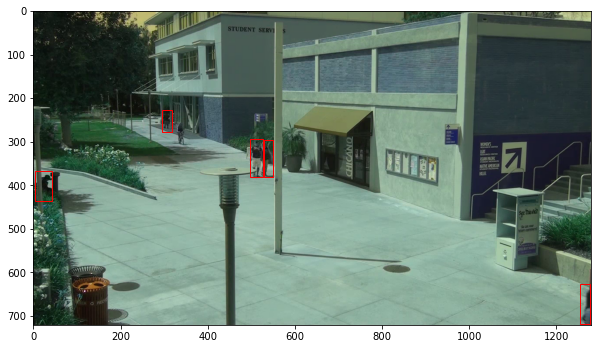

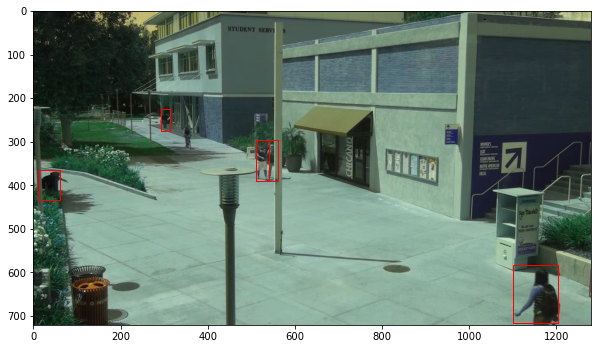

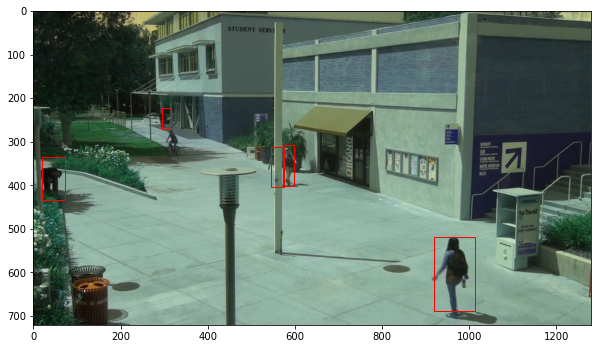

In [9]:
# View data to see some annotated frames
display.display_annotated_frame(current_video["path"], annotations_df, 180)
display.display_annotated_frame(current_video["path"], annotations_df, 200)
display.display_annotated_frame(current_video["path"], annotations_df, 240)

## Organize Directories

In [10]:
# See 20230512_YOLO Format Conversion.ipynb to see code for converting VIRAT data directories to YOLO format

## Load Pretrained Model

In [12]:
model = yolo.yolov5()

Using cache found in /home/sardarchitect/.cache/torch/hub/ultralytics_yolov5_master


requirements: /home/sardarchitect/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5 🚀 2023-4-30 Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [22]:
# Regular validation does not run due to dataset class differences on pretrained YOLO and VIRAT
# ! python /home/sardarchitect/repos/github.com/ucsd_capstone/yolov5/val.py --weights yolov5s.pt --data /home/sardarchitect/repos/github.com/ucsd_capstone/scripts/dataset.yaml --img 640

# Try custom benchmarking
def model_evaluation(model, current_video_path, current_annotations):
    capture = cv.VideoCapture(current_video_path)
    while True:
        success, current_frame = capture.read()
        predictions = model(current_frame)
        print(predictions.xyxy[0][:, :4])
        break

In [23]:
model_evaluation(model, current_video['path'], annotations_df)

tensor([[473.11847, 272.91431, 497.81525, 340.13696],
        [336.12543, 239.36133, 359.32062, 284.71582]], device='cuda:0')


## Train

## Test

## Postprocessing